# PyTorch Non-Leaf Differentiable Parameters
Keywords: "non-leaf variables as module parameters", "backproping through a model"

## Motivation
- In Meta-Learning we would like to learn how to train a network - we optimise for the optimisation algorithm itself.
- In such a situation the loss is differentiated with respect to the learning algorithm rather than the model.
- In other words the loss depends on how well the model is doing "after" training using that optimisation algorithm.
- We have the meta-learner, which produces a model, and we optimise the meta-learner based on how well the trained model is doing.
- MAML in particular does this by differentiating the loss of the trained model with respect to the meta-learner - one long backpropagation "through" the trained model.
- While this sounds like an elegant approach, this is easier said than done on a practical level.
- In this notebook we will examine the technical challenges and analyise possible solutions.


## Problem Statement
- Suppose we have two batches $B_1, B_2$, from a standard supervised problem, each with input and labels.
- We start with a model $M_1$, which we update using SGD on $B_1$ to obtain $M_2$ 
$$M_2 = M_1 - \nabla_{M_1} \mathcal{L}(M_1, B_1)$$
- Now we don't really care or want to keep $M_2$, we just want to use it to obtain an update on $M_1$ based on the performance of $M_2$ on $B_2$
$$M_1* = M_1 - \nabla_{M_1} \mathcal{L}(M_2,B_2)$$
- Unwrapping this, to emphasize that $M_2$ is just a temporary variable, we get:
$$M_1* = M_1 - \nabla_{M_1} \mathcal{L}([M_1 - \nabla_{M_1} \mathcal{L}(M_1, B_1)], B_2)$$
- However $M$ can be an arbitraty complicated neural network, so ideally we would use a `torch.nn.Module` to make use of the object-oriented paradigm and its ease of use. 
- This implies that we actually want to have the temporary network $M_2$.
- Here is where the problem comes up, as we want to backprop "through" the `torch.nn.Module` $M_2$.
- In our computational graph $M_2$ is not a leaf node, its parameters are somewhere in the middle between $M_1$ and $\mathcal{L}(M_2, B_2)$.
- Ideally this shouldn't be a problem, and we could just call backward on the outer loss to get the gradients for the $M_1$ model.
- After all, autograd is powerful enough to produce higher order derivatives
- The problem lies on a technical level - in Pytorch a model's weights are not seen as raw tensors but as `torch.nn.Parameters`, which are leaf nodes in the computational graph.
- Wrapping tensors to `torch.nn.Parameters`, or using state_dict will copy the values and detach them from their computational graph.
- These technical challenges are elaborated in the Higher paper. While theoretically a functional and OO implementation should be equivalent, in practice OO makes certain memory optimisations, such as updating variables in place, which prevent having a computational graph history for parameters.
- We need to be able to create a module that keeps track of the computational graph, which lead to the current parameters.

## Solutions
- Obviously this is a big use-case so there are specialised libraries: higher and torch-meta.
- In essense the proper way to do this is to use the functional equivalent for every operation. Functional is a pain to use for deep NNs, so it should happen behind the scenes while mainataining the OO api.
- Another, but hacky, way to do this is to replace each parameter variable with a tensor. This is the way I'll implement a prototype here. 

Linkes with discussions:
- https://discuss.pytorch.org/t/how-does-one-have-the-parameters-of-a-model-not-be-leafs/70076/6
- https://discuss.pytorch.org/t/non-leaf-variables-as-a-modules-parameters/65775

## Contents
1. Walkthrough  
    1.1 Using an optimiser  
    1.2 Autograd  
    1.3 Directly assigning tensors    
    1.4 Wrapping weights as Parameters  
    1.5 Tensor Hack  
    1.6 Using Functional  
2. Monkeypatching Prototype

In [1]:
import dill
import copy
import torch
import tempfile
from torch import nn
from torch.optim import SGD
from torchviz import make_dot

# 1. Walkthrough
- We will test some naive approaches to understand the problem
- Then we will go over attempts to tackle the non-leaf parameter problem.
- We will also see what doesn't work

In [2]:
def get_M1():
    return nn.Linear(1, 1, bias=False)

def get_random_loss(model):
    """Doesnt matter what this is as long as it can produce a gradient"""
    in_ = torch.randn(1, 1)
    out = model(in_)
    loss = out.sum()
    return loss

## 1.1 Using an optimiser
- Using the SGD optimiser to update M1
- This overwrites the parameters of M1, which becomes M2
- We lose the computational graph that has the M1 weights as leaves

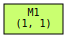

In [6]:
M1 = get_M1()
sgd = SGD(M1.parameters(), lr=1)

loss = get_random_loss(M1)
loss.backward()
sgd.step()

make_dot(M1.weight, params={"M1": M1.weight})

# 1.2 Autograd
- We definitely have to use autograd to keep the computational graph
- Now the question is what do we do with the resulting tensor M2_weight

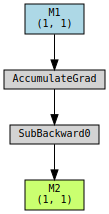

In [7]:
M1 = get_M1()
grad = torch.autograd.grad(get_random_loss(M1), M1.parameters(), retain_graph=True)[0]
M2_weight = M1.weight - grad

make_dot(M2_weight, params={"M1": M1.weight, "M2": M2_weight})

## 1.3 Directly assigning tensors
- As before we manually use autograd and compute the new weights
- We create a new model and overwrite its weights with our computed ones, hoping the graph will stay in place
- Pytorch is complaining the weights needs to be nn.Parameter not a Tensor

In [8]:
M1 = get_M1()
grad = torch.autograd.grad(get_random_loss(M1), M1.parameters(), retain_graph=True)[0]

M2_weight = M1.weight - grad
M2 = torch.nn.Linear(1, 1)
M2.weight = M2_weight

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

## 1.4. Wrapping weights as Parameters
- We saw that one can assign only nn.Parameters to model
- Let's warp the weights as parameters then
- We can see that once we do that, the compuational graph is discarded

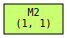

In [9]:
M1 = get_M1()
grad = torch.autograd.grad(get_random_loss(M1), M1.parameters(), retain_graph=True)[0]

M2_weight = nn.Parameter(M1.weight - grad)
M2 = torch.nn.Linear(1, 1)
M2.weight = M2_weight
M2_loss = get_random_loss(M2)

make_dot(M2.weight, params={"M1": M1.weight, "M2": M2.weight})

In [10]:
# Trying to get the gradient of the M2 loss wrt to M1 fails
torch.autograd.grad(M2_loss, M1.parameters())

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

## 1.5 Tensor Hack
- Based on https://discuss.pytorch.org/t/how-does-one-have-the-parameters-of-a-model-not-be-leafs/70076/6
- mr alband suggests del the weight parameter, then assigning the non-leaf tensor
- I would say this is more of a hack as it violates the intended use of model parameters, however if it works it works
- One would need an automated way of monkey patching a whole network this way

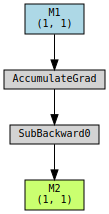

In [11]:
M1 = get_M1()
grad = torch.autograd.grad(get_random_loss(M1), M1.parameters(), retain_graph=True)[0]

M2_weight = M1.weight - grad
M2 = torch.nn.Linear(1, 1)
del M2.weight
M2.weight = M2_weight
M2_loss = get_random_loss(M2)

make_dot(M2.weight, params={"M1": M1.weight, "M2": M2.weight})

In [12]:
M2_loss.backward()
print("M1.weight has grad:", M1.weight.grad is not None)

M1.weight has grad: True


## 1.6 Using Functional
- The non-leaf variable problem arises only when using the OO implementation of pytorch models, as nn.Parameter objects are designed to be leaf variables.
- The functional api doesnt have that problem, however handling models as a nn.Modules is a lot more convenient than using a functinal implementation
- It can become quite annoying to use this approach manually which boils down to either having two implementations of a model or wrap certain modules
- However this seems to be the most legitimate solution and used by meta-learning libs 
- The key point is that one has to do this somehow under the hood, in a systematic way
- In order to not interfere with the user experience and be completely transparent the solution has to provide a stateful, OO-like api, which under the hood actually uses the functional api 
- Higher monkey-patches modules at runtime such that their operations are converted to functional blocks, while torchmeta reimplements basic layers to explicity call their functional counterparts

In [13]:
M1 = get_M1()
grad = torch.autograd.grad(get_random_loss(M1), M1.parameters(), retain_graph=True)[0]

M2_weight = M1.weight - grad
M2 = lambda x: torch.nn.functional.linear(x, weight=M2_weight)
M2_loss = get_random_loss(M2)

M2_loss.backward()
print("M1.weight has grad:", M1.weight.grad is not None)

# Case in point about functional being cumbersome, I can't plot since M2 is not a nn.Module

M1.weight has grad: True


# 2. Monkeypatching Prototype
- Am going to use the tensor hack approach and monkey patch an arbitrary model's params
- very crude approach, but is simple and works
- Test by creating an arbitrary chain of vgg models

In [14]:
def assign_differentiable_param(module, param_name: str, param: torch.Tensor):
    """
    Based on https://discuss.pytorch.org/t/how-does-one-have-the-parameters-of-a-model-not-be-leafs/70076/6
    Deletes the Parameter and replaces it with a raw Tensor.
    """
    if "." in param_name:
        sub_module = getattr(module, param_name.split(".")[0])
        suffix = ".".join(param_name.split(".")[1:])
        return assign_differentiable_param(sub_module, suffix, param)
    delattr(module, param_name)
    setattr(module, param_name, param)
    

def get_param(module, param_name: str):
    if "." in param_name:
        sub_module = getattr(module, param_name.split(".")[0])
        suffix = ".".join(param_name.split(".")[1:])
        return get_param(sub_module, suffix)
    return getattr(module, param_name)


def create_differentiable_model(base_model, params: dict = None):
    """
    Creata a model with differentiable parameters from a base model.
    If params is not None, assign those parameters, otherwise make old ones differentiable.
    Also works if base_model is aready differentiable.
    """
    try:
        diff_model = copy.deepcopy(base_model)
    except RuntimeError:
        # Can't copy a non-leaf parameter model
        # https://stackoverflow.com/questions/56590886/how-to-solve-the-run-time-error-only-tensors-created-explicitly-by-the-user-gr
        with tempfile.NamedTemporaryFile() as tmp:
            # Need dill because of the lambdas
            torch.save(base_model, tmp.name, pickle_module=dill)
            diff_model = torch.load(tmp.name, pickle_module=dill)
    
    if params is None:
        params = {param_name: param + 0 for param_name, param in base_model.named_parameters()}
    
    for param_name, param in params.items():
        assign_differentiable_param(diff_model, param_name, param)
    
    # Note: by using this hacky monkey patching the new model doesnt have parametes anymore, only tensors. 
    # This means the get_parameters() won't return anything. We need to patch that, further going down the rabbit hole.
    diff_model.parameter_names = list(params.keys())
    diff_model.named_parameters = lambda: {name: get_param(diff_model, name) for name in diff_model.parameter_names}.items()
    diff_model.parameters = lambda: [get_param(diff_model, name) for name in diff_model.parameter_names]
    return diff_model

## 2.1 Testing on VGG
- Using VGG as it has a bunch of different layer types
- Unrolling it 3 times: Base -> M1 -> M2 -> M3
- Get grads of loss M3 wrt to Base

In [15]:
from torchvision.models import vgg11_bn

base_model = vgg11_bn()
diff_model = base_model

batch_size = 5
get_batch = lambda: (torch.randn(batch_size, 3, 32, 32), torch.randint(high=1000, size=(batch_size,)))


for _ in range(3):
    X, y = get_batch()
    loss = nn.functional.cross_entropy(diff_model(X), y)
    grads = torch.autograd.grad(loss, diff_model.parameters(), retain_graph=True)
    new_params = {key: param - grad for (key, param), grad in zip(diff_model.named_parameters(), grads)}
    diff_model = create_differentiable_model(diff_model, new_params)
    
X, y = get_batch()
loss = nn.functional.cross_entropy(diff_model(X), y)

In [16]:
print("base_model grads are None:", base_model.features[0].weight.grad is None)

base_model grads are None: True


In [18]:
loss.backward() # loss of M3
print("base_model grads are NOT None now:", base_model.features[0].weight.grad is not None)

base_model grads are NOT None now: True


# Summary
- `nn.Parameters` are by design leaf nodes in the computational graph
- Overwriting them naively doesn't work: `nn.Module`s require `nn.Parameters` not tensors
- Specialised libraries use `nn.functional` under the hood
- A hacky way to monkey-patch is to force a `nn.Module` to use raw tensors (del parameters)
    - Implemented a working prototype of such a wrapper that works for arbitrary architectures and multiple inner loops